# **GPyTorch Deep Gaussian Processes Tutorial**

This notebook illustrates the use of deep Gaussian processes for regression and classification using GPyTorch. We will consider the implementation described by Salimbeni, using doubly stochastic variational inference (https://arxiv.org/abs/1705.08933).

Deep GPs are only partially implemented in GPytorch and we will have to do many high level things on our own, such as creating the model, propagating samples across layers, etc.

In [1]:
!pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 5.5 MB/s eta 0:00:00


For simplicity, we avoid using GPU acceleration and do the necessary imports.


In [2]:
%set_env CUDA_VISIBLE_DEVICES=0

import torch
import tqdm
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import UnwhitenedVariationalStrategy, VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood

from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

from matplotlib import pyplot as plt

env: CUDA_VISIBLE_DEVICES=0


## **Generating the Training Data**

For simplicity we will consider a simple dataset given by the step function considered in the lectures. This dataset is highly non-smooth, which means that standard GPs may have problems here.

In [3]:
N = 20

# Training data are N points regularly spaced in the interval [-2,2].

train_x = torch.linspace(-2, 2, N).reshape((N,1))

# True function is 0 or 1 depending on the input location

train_y = torch.remainder(torch.round(torch.remainder(train_x, 2.0)), 2.0)

We plot the data for visualization.

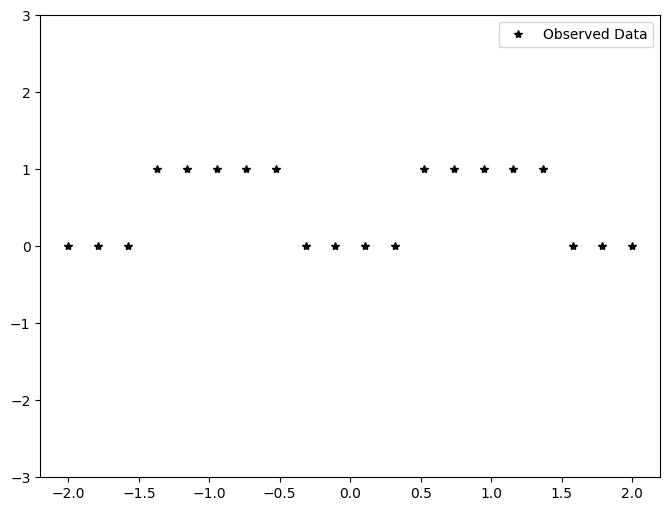

In [4]:
# Initialize plot

f, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot training data as black stars

ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data'])

## **Defining GP layers**

In GPyTorch, defining a GP involves extending one of our abstract GP models and defining a forward method that returns the prior. For deep GPs, things are similar, but there are two abstract GP models that must be overwritten: one for hidden layers and one for the deep GP model itself.

In the next cell, we define an example deep GP hidden layer. This looks very similar to every other variational GP you might define. However, there are a few key differences:

*   Instead of extending ApproximateGP, we extend DeepGPLayer.


DeepGPLayers need a number of input dimensions, a number of output dimensions, and a number of samples. This is kind of like a linear layer in a standard neural network (input_dims defines how many inputs this hidden layer will expect), and output_dims defines how many hidden GPs to create outputs for.

To facilitate training, each layer will model variations across the identity function. For this, we consdier a mean function for the GP of each layer equal to the identy function, except for the last layer.

In [5]:
from gpytorch.means import ZeroMean, LinearMean

# We create our layer object. Each layer will have a constant mean equal to the
# identity function, except the last layer.

class DeepGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing, inducing_points = None, initial_inducing_values = None):

        # The last layer should have output_dims equal to None.

        if output_dims is None:
            batch_shape = torch.Size([])
        else:
            batch_shape = torch.Size([output_dims])

        # We use a clever initialization of the layers to be similar to the
        # identity function. This facilitates training.

        if inducing_points is None and initial_inducing_values is None:
            if output_dims is None:
                inducing_points = torch.randn(num_inducing, input_dims) * 2.0
                initial_inducing_values = inducing_points[:,0]
            else:
                inducing_points = torch.randn(output_dims, num_inducing, input_dims) * 2.0
                initial_inducing_values = inducing_points[0,:,0]
        else:
            inducing_points = inducing_points[None,:,:]

        variational_distribution = CholeskyVariationalDistribution(num_inducing_points=num_inducing, batch_shape=batch_shape)
        variational_distribution.initialize_variational_distribution(MultivariateNormal(initial_inducing_values, torch.eye(num_inducing) * 1e-5))
        variational_strategy = UnwhitenedVariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        variational_strategy.variational_params_initialized = torch.tensor(1)

        super(DeepGPHiddenLayer, self).__init__(variational_strategy, input_dims, output_dims)

        # The mean function is zero.

        self.mean_module = ZeroMean(batch_shape=batch_shape)
        self.covar_module = ScaleKernel(RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims), \
            batch_shape=batch_shape, ard_num_dims=None)

    def forward(self, x):

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return MultivariateNormal(mean_x, covar_x)

## **Building the deep GP**

Now that we’ve defined a class for our hidden layers and a class for our output layer, we can build our deep GP. To do this, we create a Module whose forward is simply responsible for forwarding through the various layers. This also allows to evaluate individually each layer. For example calling, output_layer_2 = self.second_hidden_layer(inputs).




In [6]:
# We create the deep GP

class DSVIDeepGP(DeepGP):
    def __init__(self, train_x, train_y, train_x_shape, num_hidden_dims, num_inducing):

        to_sel = torch.randperm(train_x.shape[ 0 ])[ 0 : num_inducing]
        inducing_points = train_x[ to_sel, : ]
        inducing_values = train_y[ to_sel, 0 ]

        # We create the layers. Recall that the outputdims of the last layer should be none.

        hidden_layer = DeepGPHiddenLayer(input_dims=train_x_shape[-1], \
                output_dims=num_hidden_dims, num_inducing = num_inducing, inducing_points = inducing_points,
                initial_inducing_values = inducing_values)

        last_layer = DeepGPHiddenLayer(input_dims=hidden_layer.output_dims, \
                output_dims=None, num_inducing = num_inducing)

        super().__init__()

        self.hidden_layer = hidden_layer
        self.last_layer = last_layer
        self.likelihood = GaussianLikelihood()
        self.likelihood.noise = 0.01

    def forward(self, inputs):

        # The forward method simply let the data go through each layer by
        # sampling from the predictive distribution of each layer.

        hidden_rep = self.hidden_layer(inputs)
        output = self.last_layer(hidden_rep.rsample())

        return output

    def predict(self, test_data, num_samples = 100):

        # We compute predictions for the test data for the whole model

        with torch.no_grad():
            means = torch.zeros(test_data.shape[ 0 ], num_samples)
            variances = torch.zeros(test_data.shape[ 0 ], num_samples)
            for i in range(num_samples):
                with gpytorch.settings.num_likelihood_samples(1):
                  preds = self.likelihood(self(test_data))
                  means[ :, i ] = preds.mean
                  variances[ :, i ] = preds.variance

        return means, variances

After this, we are ready to create our DGP using the training data.

In [19]:
num_inducing_points = 10
model = DSVIDeepGP(train_x, train_y, train_x.shape, 1, num_inducing_points)

Now, we are ready to train the model. We will use ADAM for that. The loss is the specific loss for DGPs that will consider the DSVI objective. This loss is already implemented in gpytorch.

In [20]:
from torch.utils.data import TensorDataset, DataLoader

def train_dgp_dsvi(model, train_x, train_y, mini_batch_size, num_epochs, num_samples = 1):

  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, train_x.shape[-2]))

  for training_iter in range(num_epochs):

    # Within each iteration, we will go over each minibatch of data

    train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=mini_batch_size, shuffle=True)

    for (x_batch, y_batch) in train_loader:

        # We iterate over the batches

        with gpytorch.settings.num_likelihood_samples(num_samples):
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch.T)
            loss.backward()
            optimizer.step()

    if (training_iter + 1) % 100 == 0:
      print('Epoch %d/%d - Loss: %f' % (training_iter + 1, num_epochs, loss.item() * train_x.shape[ 0 ]))

Now, we train the model.

In [21]:
train_dgp_dsvi(model, train_x, train_y, train_x.shape[ 0 ], 10000)

Epoch 100/5000 - Loss: 24.229298
Epoch 200/5000 - Loss: 17.149851
Epoch 300/5000 - Loss: 16.335349
Epoch 400/5000 - Loss: 19.012232
Epoch 500/5000 - Loss: 14.759666
Epoch 600/5000 - Loss: 11.220680
Epoch 700/5000 - Loss: 13.231179
Epoch 800/5000 - Loss: 11.363344
Epoch 900/5000 - Loss: 12.212919
Epoch 1000/5000 - Loss: 8.670955
Epoch 1100/5000 - Loss: 17.477371
Epoch 1200/5000 - Loss: 16.016691
Epoch 1300/5000 - Loss: 12.924122
Epoch 1400/5000 - Loss: 7.447813
Epoch 1500/5000 - Loss: 20.431340
Epoch 1600/5000 - Loss: 8.538160
Epoch 1700/5000 - Loss: 5.056489
Epoch 1800/5000 - Loss: 12.538687
Epoch 1900/5000 - Loss: 9.742444
Epoch 2000/5000 - Loss: 5.337696
Epoch 2100/5000 - Loss: 6.091132
Epoch 2200/5000 - Loss: 15.247871
Epoch 2300/5000 - Loss: 10.536311
Epoch 2400/5000 - Loss: 5.861516
Epoch 2500/5000 - Loss: 7.431848
Epoch 2600/5000 - Loss: 6.952381
Epoch 2700/5000 - Loss: 5.544944
Epoch 2800/5000 - Loss: 7.224901
Epoch 2900/5000 - Loss: 13.618395
Epoch 3000/5000 - Loss: 5.677745
Ep

We now compute predictions and plot the predictive distribution.





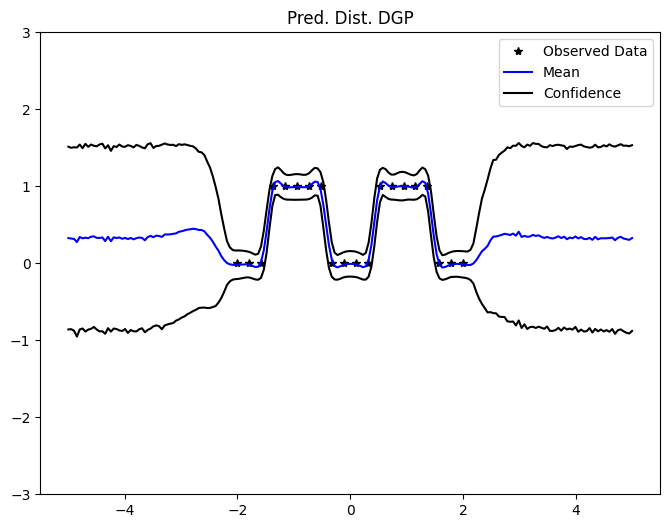

In [25]:
import numpy as np

x_test = torch.linspace(-5,5,200).reshape((200, 1))
means, variances = model.predict(x_test, num_samples = 1000)

mean = torch.mean(means, -1)
var  = torch.mean(means**2 + variances, -1) - mean**2

def plot_predictive_dgp(mean, var, title):
  f, ax = plt.subplots(1, 1, figsize=(8, 6))
  lower = mean + 2.0 * np.sqrt(var)
  upper = mean - 2.0 * np.sqrt(var)
  ax.plot(train_x, train_y, 'k*')
  ax.plot(x_test, mean, 'b')
  ax.plot(x_test, upper, 'black')
  ax.plot(x_test, lower, 'black')
  ax.set_ylim([-3, 3])
  ax.legend(['Observed Data', 'Mean', 'Confidence'])
  ax.set_title(title)
  f.show()

plot_predictive_dgp(mean, var, "Pred. Dist. DGP")

Now we do the same for each layer.




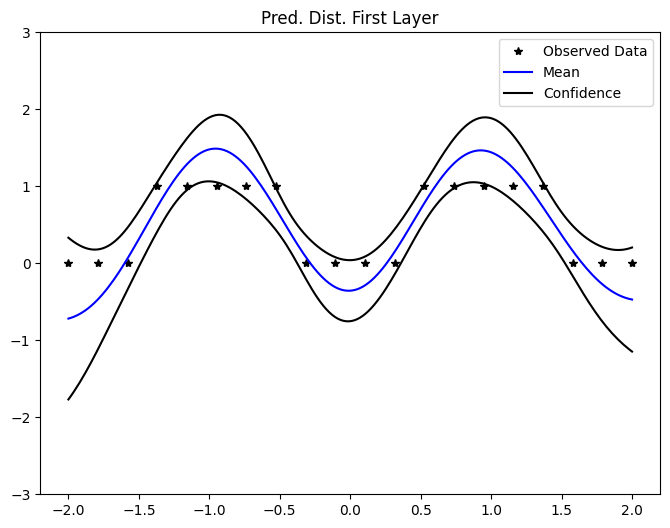

In [11]:
# First layer

x_test = torch.linspace(-2,2,200).reshape((200, 1))
with torch.no_grad():
  with gpytorch.settings.num_likelihood_samples(1):
    pred = model.hidden_layer(x_test)

mean = pred.mean.mean(-1).T
var  = pred.variance.mean(-1).T
plot_predictive_dgp(mean, var, "Pred. Dist. First Layer")

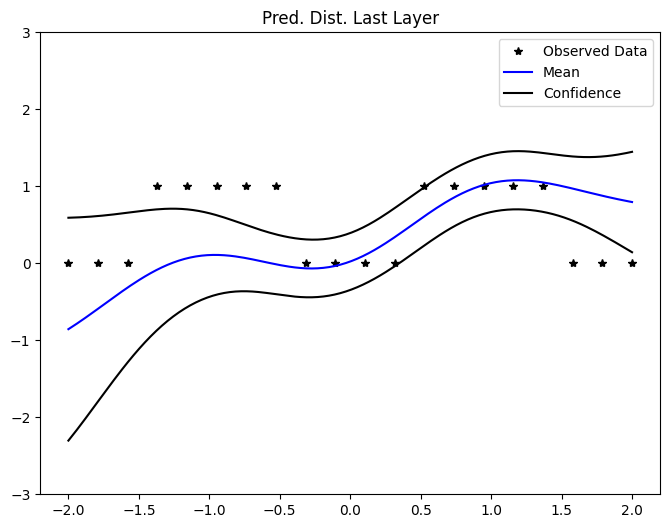

In [12]:
# Last layer

x_test = torch.linspace(-2,2,200).reshape((200, 1))
with torch.no_grad():
  with gpytorch.settings.num_likelihood_samples(1):
    pred = model.likelihood(model.last_layer(x_test))

mean = pred.mean.T
var  = pred.variance.T
plot_predictive_dgp(mean, var, "Pred. Dist. Last Layer")

## **Comparison with a standard Sparse GP**
For a reference, we show also the results of a standard sparse GP with the same number of inducing points.

In [13]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy

# We define our approximate GP method based on the VFE approach

class VFESparseGP(ApproximateGP):
    def __init__(self, inducing_points):

        # We use a zero mean and an RBF kernel

        mean_module = gpytorch.means.ZeroMean()
        covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        # We use a cholesky factorization to represent the parameters of the
        # variational approximate distribution q

        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0), mean_init_std=0.0)

        # We initialize the variational distribution

        init_dist = gpytorch.distributions.MultivariateNormal(torch.zeros(inducing_points.size(0)), \
            covar_module(inducing_points) * 1e-5)

        variational_distribution.initialize_variational_distribution(init_dist)

        # We use an unwhitened variational strategy. Whitening is also possible and
        # described later on.

        variational_strategy = UnwhitenedVariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        variational_strategy.variational_params_initialized = torch.tensor(1) # XXX DHL This avoids random initialization

        super(VFESparseGP, self).__init__(variational_strategy)

        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def train_model(model, mll, train_x, train_y, training_iter = 10, likelihood = None):

  model.train()
  losses = torch.zeros(training_iter)

  # We check if we have to optimize the likelihood too or it is already in the
  # model

  if likelihood is None:
    params = model.parameters()
  else:
    params = list(model.parameters()) + list(likelihood.parameters())

  # We instantiate the LBFGS optimizer, which will optimize the hyper-parameters.

  optimizer = torch.optim.LBFGS(params, \
      history_size=10, max_iter=4, line_search_fn="strong_wolfe")

  def closure():
      optimizer.zero_grad()
      output = model(train_x)
      loss = -mll(output, train_y)
      loss.backward()
      return loss

  for i in range(training_iter):

    loss = -mll(model(train_x), train_y) * train_x.shape[ 0 ]
    print('Iter %d/%d - Loss: %f' % (i + 1, training_iter, loss.item()))
    losses[ i ] = torch.from_numpy(np.array([loss.item()]))

    optimizer.step(closure)

  return losses

We fit the model and we print the predictive distribution.

In [14]:
from gpytorch.mlls import VariationalELBO
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

M = 10
inducing_points = train_x[ torch.randperm(train_x.shape[ 0 ])[ 0 : M ], 0 ]
model_vfe = VFESparseGP(inducing_points)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

start = time.time()
result_unwhitened = train_model(model_vfe, mll, train_x[:,0], train_y[:,0], 500, likelihood)
end = time.time()

print("Total training time:", end - start)

Iter 1/500 - Loss: 68.235687
Iter 2/500 - Loss: 37.201416
Iter 3/500 - Loss: 28.235363
Iter 4/500 - Loss: 21.783850
Iter 5/500 - Loss: 19.141682
Iter 6/500 - Loss: 18.060263
Iter 7/500 - Loss: 17.877708
Iter 8/500 - Loss: 17.605824
Iter 9/500 - Loss: 17.524082
Iter 10/500 - Loss: 17.517149
Iter 11/500 - Loss: 17.517149
Iter 12/500 - Loss: 17.517149
Iter 13/500 - Loss: 17.517149
Iter 14/500 - Loss: 17.517149
Iter 15/500 - Loss: 17.517149
Iter 16/500 - Loss: 17.517149
Iter 17/500 - Loss: 17.517149
Iter 18/500 - Loss: 17.517149
Iter 19/500 - Loss: 17.517149
Iter 20/500 - Loss: 17.517149
Iter 21/500 - Loss: 17.517149
Iter 22/500 - Loss: 17.517149
Iter 23/500 - Loss: 17.517149
Iter 24/500 - Loss: 17.517149
Iter 25/500 - Loss: 17.517149
Iter 26/500 - Loss: 17.517149
Iter 27/500 - Loss: 17.517149
Iter 28/500 - Loss: 17.517149
Iter 29/500 - Loss: 17.517149
Iter 30/500 - Loss: 17.517149
Iter 31/500 - Loss: 17.517149
Iter 32/500 - Loss: 17.517149
Iter 33/500 - Loss: 17.517149
Iter 34/500 - Loss:

Now we plot the predictive distribution.

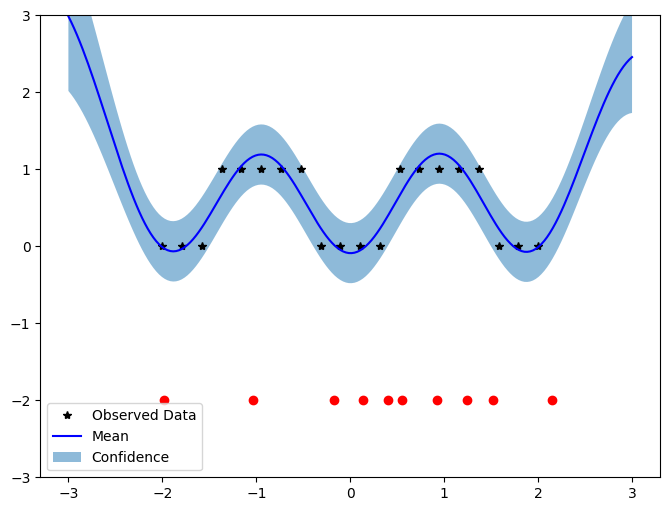

In [15]:
def plot_pred_dist_model(model, likelihood):

  model.eval()
  likelihood.eval()

  # Test points are regularly spaced along [-2, 8].
  # Make predictions for y by feeding model through likelihood.

  with torch.no_grad():
      test_x = torch.linspace(-3, 3, 200)
      predictions = likelihood(model(test_x))

  # We plot the predictive distribution (mean +- standard deviation).

  f, ax = plt.subplots(1, 1, figsize=(8, 6))
  lower, upper = predictions.confidence_region()
  ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
  ax.plot(test_x.numpy(), predictions.mean.numpy(), 'b')
  ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
  ax.set_ylim([-3, 3])
  ax.legend(['Observed Data', 'Mean', 'Confidence'])
  return ax

ax = plot_pred_dist_model(model_vfe, likelihood)

with torch.no_grad():
  ax.plot(model_vfe.variational_strategy.inducing_points, torch.ones(M).numpy() * -2, "ro")


## **Task 1**

Try to add another hiden layer in the previous DGP model to see what impact it has in the predictive distribution. Ideall, it should improve it a bit. Use the same settings, e.g., number of inducing points, training epochs, etc. Plot the latent function learned at each layer: first, second and last.

## **Training DGPs by Minimizing Alpha-Divergences**

In this part of the notebook we will focuse on training DGPs by minimizing alpha-divergences. Training by minimizing alpha-divergences is not implemented in gpytorch. However, gpytorch is very easy to extend to incorporate this funcitonality. We only need to create a custom loss function.

The implementation is veary easy. It simply duplicates the data fed into the model times the number of samples used in the Monte Carlo approximation of the $\log Z_i$ terms. The loss function ueses these repeated predictions to estimate $\log Z_i$ acordingly.

In [16]:
# This class implements the approximate alpha-divergence objective
# It only changes the computation of the data-dependent term w.r.t. DSVI.
# The regularizer, the KL-divergence, is the same.

import numpy as np

class VariationalELBOAlphaDivergence(VariationalELBO):
    def __init__(self, likelihood, model, train_size, alpha_value, n_samples_train):
        super().__init__(likelihood, model, train_size)
        self.alpha_value = alpha_value
        self.n_samples_train = n_samples_train

    def _log_likelihood_term(self, variational_dist_f, target, **kwargs):

        mean = variational_dist_f.mean
        variance = variational_dist_f.variance

        mean = mean.reshape((mean.shape[ 0 ], self.n_samples_train, int(mean.shape[ -1 ] / self.n_samples_train)))
        variance = variance.reshape((variance.shape[ 0 ], self.n_samples_train, int(variance.shape[ -1 ] / self.n_samples_train)))
        noise = self.likelihood.noise[ 0 ]
        target_new = target.reshape((target.shape[ 0 ], self.n_samples_train, int(target.shape[ -1 ] / self.n_samples_train)))

        # This is the log value of the expectation of a gaussian factor to the power of alpha

        log_probs = self.alpha_value * (-0.5 * np.log(2 * np.pi) - 0.5 * torch.log(noise)) \
            + (0.5 * np.log(2 * np.pi) + 0.5 * torch.log(noise / self.alpha_value)) \
            + (-0.5 * np.log(2 * np.pi) - 0.5 * torch.log(noise / self.alpha_value + variance)) \
            + - 0.5 * (mean - target_new)**2 / (variance + noise / self.alpha_value)
        expected_log_probs = torch.logsumexp(log_probs, 1) - np.log(self.n_samples_train)

        return (1 / self.alpha_value * expected_log_probs.sum(-1)) * self.n_samples_train # We multiply by the sample size to account for the size of the actual batch inserted


Now we slightly change the optimizar to take into account the new loss.

In [23]:
from torch.utils.data import TensorDataset, DataLoader

def train_dgp_alpha(model, train_x, train_y, mini_batch_size, num_epochs, n_samples_train = 25, alpha = 1e-3):

  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  mll = DeepApproximateMLL(VariationalELBOAlphaDivergence(model.likelihood, model, train_x.shape[-2], alpha, n_samples_train))

  for training_iter in range(num_epochs):

    # Within each iteration, we will go over each minibatch of data

    train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=mini_batch_size, shuffle=True)

    for (x_batch, y_batch) in train_loader:

        # We iterate over the batches

        with gpytorch.settings.num_likelihood_samples(1):
            optimizer.zero_grad()
            x_tiled = torch.tile(x_batch, ((n_samples_train, 1)))
            y_tiled = torch.tile(y_batch, ((n_samples_train, 1)))
            output = model(x_tiled)
            loss = -mll(output, y_tiled.T)
            loss.backward()
            optimizer.step()

    if (training_iter + 1) % 100 == 0:
      print('Epoch %d/%d - Loss: %f' % (training_iter + 1, num_epochs, loss.item() * train_x.shape[ 0 ]))

Now we are ready to train the method.

In [30]:
# We instantiate the model

num_inducing_points = 10
model = DSVIDeepGP(train_x, train_y, train_x.shape, 1, num_inducing_points)

# We do the actual training

train_dgp_alpha(model, train_x, train_y, train_x.shape[ 0 ], 10000, alpha = 1.0)

Epoch 100/10000 - Loss: 20.932131
Epoch 200/10000 - Loss: 15.721507
Epoch 300/10000 - Loss: 10.993221
Epoch 400/10000 - Loss: 7.193576
Epoch 500/10000 - Loss: 3.418438
Epoch 600/10000 - Loss: 8.531016
Epoch 700/10000 - Loss: 12.253973
Epoch 800/10000 - Loss: 4.511647
Epoch 900/10000 - Loss: -0.399699
Epoch 1000/10000 - Loss: -0.697861
Epoch 1100/10000 - Loss: -1.563795
Epoch 1200/10000 - Loss: -7.923474
Epoch 1300/10000 - Loss: -6.700504
Epoch 1400/10000 - Loss: -12.051363
Epoch 1500/10000 - Loss: -11.434596
Epoch 1600/10000 - Loss: -14.973233
Epoch 1700/10000 - Loss: -15.171769
Epoch 1800/10000 - Loss: -16.923320
Epoch 1900/10000 - Loss: -13.262491
Epoch 2000/10000 - Loss: -17.283978
Epoch 2100/10000 - Loss: -6.309185
Epoch 2200/10000 - Loss: -11.524940
Epoch 2300/10000 - Loss: -19.579780
Epoch 2400/10000 - Loss: -20.365686
Epoch 2500/10000 - Loss: -18.981037
Epoch 2600/10000 - Loss: -21.160288
Epoch 2700/10000 - Loss: -21.424904
Epoch 2800/10000 - Loss: -20.177250
Epoch 2900/10000 - 

We now compute predictions and plot the predictive distribution.



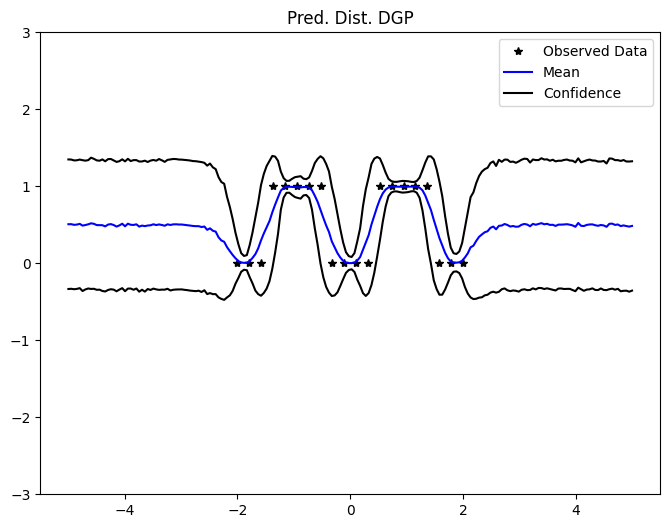

In [31]:
import numpy as np

x_test = torch.linspace(-5,5,200).reshape((200, 1))
means, variances = model.predict(x_test, num_samples = 1000)

mean = torch.mean(means, -1)
var  = torch.mean(means**2 + variances, -1) - mean**2

plot_predictive_dgp(mean, var, "Pred. Dist. DGP")

Now we do the same for each layer.

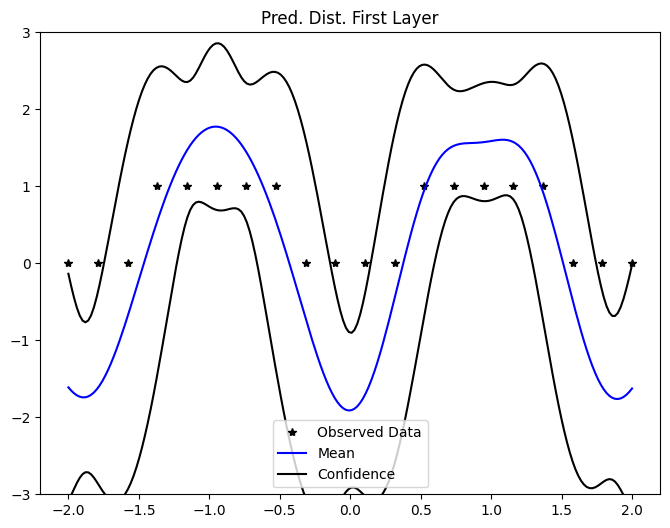

In [32]:
# First layer

x_test = torch.linspace(-2,2,200).reshape((200, 1))
with torch.no_grad():
  with gpytorch.settings.num_likelihood_samples(1):
    pred = model.hidden_layer(x_test)

mean = pred.mean.mean(-1).T
var  = pred.variance.mean(-1).T
plot_predictive_dgp(mean, var, "Pred. Dist. First Layer")

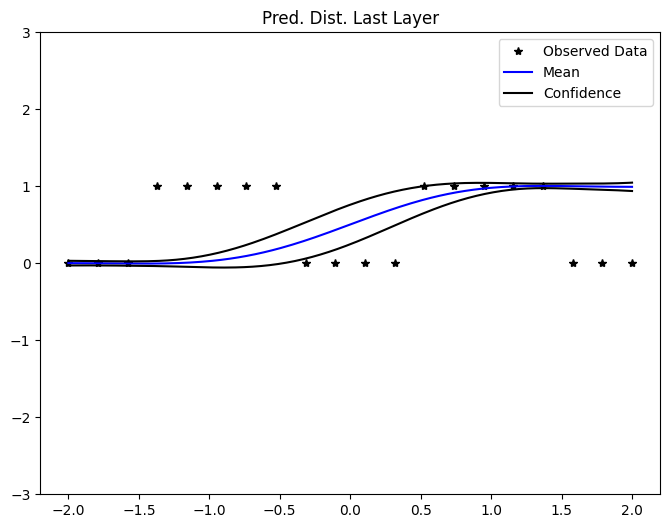

In [33]:
# Last layer

x_test = torch.linspace(-2,2,200).reshape((200, 1))
with torch.no_grad():
  with gpytorch.settings.num_likelihood_samples(1):
    pred = model.likelihood(model.last_layer(x_test))

mean = pred.mean.T
var  = pred.variance.T
plot_predictive_dgp(mean, var, "Pred. Dist. Last Layer")

## **Capturing Input Dependent Noise**

In this section of the notebook the goal is to DGPs to capture input dependent noise, using high values of alpha. For this, we consider a simple toy dataset similar to the one described in (https://arxiv.org/pdf/1605.07127v1.pdf).

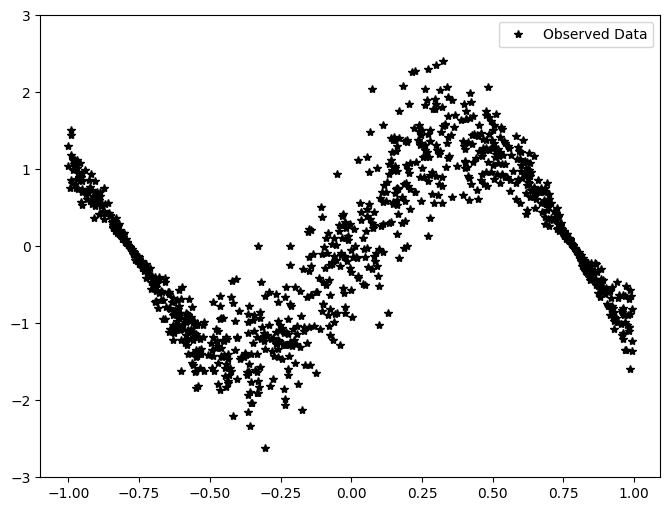

In [55]:
N = 1000

# Training data are N points regularly spaced in the interval [-2,2].

train_x_h = torch.rand(N) * 8 - 4
train_y_h = 7 * torch.sin(train_x_h) + 3 * torch.abs(torch.cos(train_x_h / 2)) * torch.randn(N)
train_x_h /= 4.0
train_y_h /= 5.0
train_x_h = train_x_h.reshape((N, 1))
train_y_h = train_y_h.reshape((N, 1))


# We plot the data for visualization

# Initialize plot

f, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot training data as black stars

ax.plot(train_x_h.numpy(), train_y_h.numpy(), 'k*')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data'])

Now we train the model, first by we will try using DSVI.

In [56]:
# We instantiate the model

num_inducing_points = 10
model = DSVIDeepGP(train_x_h, train_y_h, train_x_h.shape, 1, num_inducing_points)

# We do the actual training

train_dgp_dsvi(model, train_x_h, train_y_h, train_x_h.shape[ 0 ], 5000)

Epoch 100/5000 - Loss: 2182.400227
Epoch 200/5000 - Loss: 1207.588792
Epoch 300/5000 - Loss: 805.267096
Epoch 400/5000 - Loss: 622.834921
Epoch 500/5000 - Loss: 534.549177
Epoch 600/5000 - Loss: 482.947558
Epoch 700/5000 - Loss: 461.553872
Epoch 800/5000 - Loss: 445.757538
Epoch 900/5000 - Loss: 434.718907
Epoch 1000/5000 - Loss: 433.457077
Epoch 1100/5000 - Loss: 429.918468
Epoch 1200/5000 - Loss: 425.516188
Epoch 1300/5000 - Loss: 428.242415
Epoch 1400/5000 - Loss: 425.608873
Epoch 1500/5000 - Loss: 423.129320
Epoch 1600/5000 - Loss: 422.811508
Epoch 1700/5000 - Loss: 423.646897
Epoch 1800/5000 - Loss: 421.996772
Epoch 1900/5000 - Loss: 420.757502
Epoch 2000/5000 - Loss: 429.747105
Epoch 2100/5000 - Loss: 421.696514
Epoch 2200/5000 - Loss: 425.018191
Epoch 2300/5000 - Loss: 425.870895
Epoch 2400/5000 - Loss: 420.838922
Epoch 2500/5000 - Loss: 420.788497
Epoch 2600/5000 - Loss: 428.690255
Epoch 2700/5000 - Loss: 425.043821
Epoch 2800/5000 - Loss: 422.406435
Epoch 2900/5000 - Loss: 421

We plot the predictive distribution. In particular, we sample from it and plot the corresponding samples.

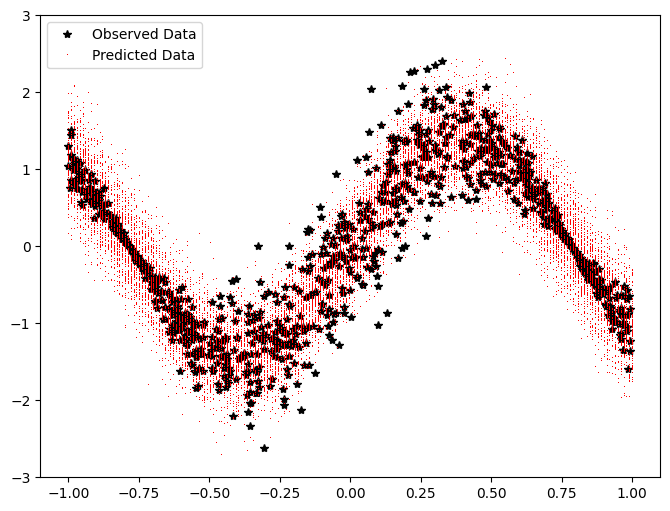

In [57]:
import numpy as np

x_test = torch.linspace(-1,1,200).reshape((200, 1))
means, variances = model.predict(x_test, num_samples = 100)

# We generate samples from the predictive distribution

samples = torch.randn(*means.shape) * torch.sqrt(variances) + means

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(train_x_h.numpy(), train_y_h.numpy(), 'k*')
for i in range(100):
  ax.plot(x_test.numpy(), samples[:,i].numpy(), ',', color = "red")
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Predicted Data'])


As we can se DVSVI results in a predictive distribution that cannot capture the input dependent noise.

## **Task 2**
Try to improve the modeling of the predictive distribution by:


*   Optimizing alpha-diverngences. In particular, try to use alpha != 0.0, for training the model.
*   Adding more units to the hidden layer. For this, simply specify a higher number of units in the hidden layer when instantiating the DGP objecto.

Take a look at the resulting predictive distribution and see what values of alpha/architectures work better.

